In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 3.9 MB/s 
     |████████████████████████████████| 3.3 MB 24.2 MB/s 
     |████████████████████████████████| 636 kB 49.1 MB/s 
     |████████████████████████████████| 895 kB 57.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
import torch.nn as nn

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Text Classification')

In [ ]:
#! unzip archive\ \(1\).zip

In [ ]:
! ls

'Copy of data.ipynb'   Corona_NLP_test.csv   Corona_NLP_train.csv   data.ipynb


In [ ]:
import chardet
with open('Corona_NLP_test.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [ ]:
import pandas as pd


In [ ]:
train_data=pd.read_csv('Corona_NLP_train.csv',encoding='ISO-8859-1')
test_data=pd.read_csv('Corona_NLP_test.csv')

In [ ]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
len(train_data)

41157

In [ ]:
train_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


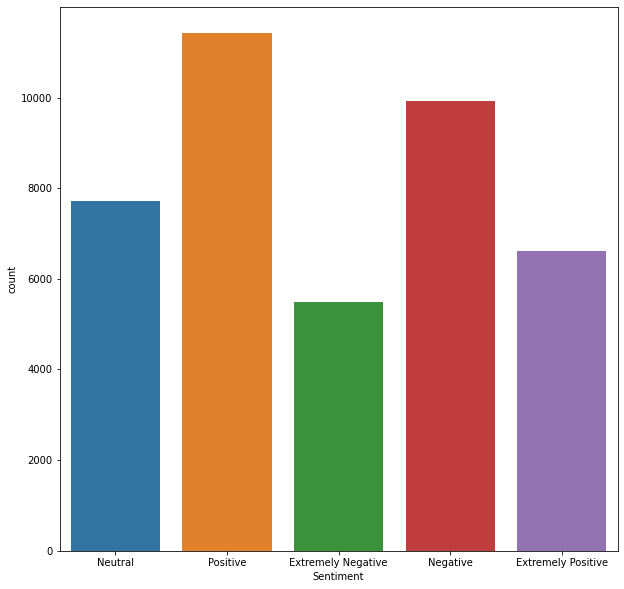

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(train_data.Sentiment)

In [ ]:
lable_dict={}
for i in train_data.Sentiment:
  if i not in lable_dict:
    lable_dict[i]=len(lable_dict)


In [ ]:
lable_dict

{'Extremely Negative': 2,
 'Extremely Positive': 4,
 'Negative': 3,
 'Neutral': 0,
 'Positive': 1}

In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def token_counter(text, tokenizer):
    return len(tokenizer.encode(text))

tok_len = train_data["OriginalTweet"].apply(lambda x : token_counter(x, tokenizer))

max(list(tok_len))

184

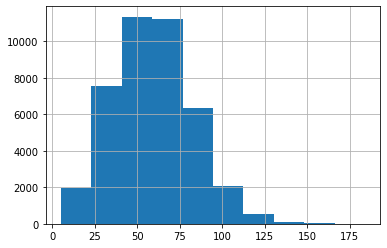

count    41157.000000
mean        58.824307
std         23.142010
min          5.000000
25%         42.000000
50%         58.000000
75%         74.000000
max        184.000000
Name: OriginalTweet, dtype: float64

In [ ]:
pd.Series(tok_len).hist()
plt.show()
pd.Series(tok_len).describe()

In [ ]:
sen_len=90
num_lables=5

In [ ]:
tokenizer.model_max_length=sen_len

In [ ]:
import re

def remove_links(text):
    to_remove = ['\r','\n',',',';',':','.']
    
    out = re.sub(r'http\S+', '', text)
    
    for token in to_remove:
        out = out.replace(token, '')
    
    return re.sub(' +', ' ', out.lower()) #Remove duplicate spaces

def tokenize(text, tokenizer):
    return tokenizer.encode(text, padding='max_length',truncation='only_first')

name_to_idx = {
    "Extremely Negative" : 0,
    "Negative" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Extremely Positive" : 4
}

def process_tgt(value):
    return name_to_idx[value]

In [ ]:
import random
example=random.choice(train_data['OriginalTweet'].to_list())
print("EXAMPLE:\n",example)
print("\nPRE-PROCESSED:\n",remove_links(example))
print("\nTOKENIZED\n",tokenize(remove_links(example),tokenizer))

EXAMPLE:


https://t.co/oiQ3o54yTU

PRE-PROCESSED:
 birmingham supermarket shelves left bare as #coronavirus panic-buying continues

TOKENIZED
 [0, 428, 853, 42754, 12647, 14169, 314, 10905, 25, 849, 7215, 261, 1469, 19473, 9810, 12, 9519, 4048, 1388, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
train_text = list(train_data["OriginalTweet"].apply(remove_links).apply(lambda x : tokenize(x, tokenizer)))
train_labels = list(train_data["Sentiment"].apply(process_tgt))

test_text = list(test_data["OriginalTweet"].apply(remove_links).apply(lambda x : tokenize(x, tokenizer)))
test_labels = list(test_data["Sentiment"].apply(process_tgt))

In [ ]:
print("Train data ",len(train_text))
print("Test data ",len(test_text))

Train data  41157
Test data  3798


In [ ]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        
        
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)

train_dataset = CreateDataset(train_text, train_labels)
test_dataset = CreateDataset(test_text, test_labels)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)

In [ ]:
for i,exp in enumerate(train_loader):
  print(exp[0].shape,exp[1].shape)
  break

torch.Size([32, 90]) torch.Size([32])


In [ ]:
class LSTMModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers,
                            dropout = dropout,
                            batch_first = True,
                            bidirectional = True)
        self.linear = nn.Linear(512*90, 5)  #2*max_len_sen*hidden_size
        
    def forward(self, inputs):
        emb = self.embedding(inputs)
        lstm_out, _ = self.lstm(emb)
        
        output = self.linear(lstm_out.reshape(lstm_out.size()[0], -1))
        
        return output
    
model = LSTMModel(tokenizer.vocab_size, 256, 256, 4, 0.2)


In [ ]:
[torch.FloatTensor]*len((1,90))

[torch.FloatTensor, torch.FloatTensor]

In [ ]:
from torchsummary import summary

summary(model,input_size=(1,90), dtypes=[torch.long,torch.long])

TypeError: ignored

In [ ]:
from tqdm import tqdm

class Trainer():
    
    def __init__(self, model, train_loader, valid_loader):
        
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def train_epoch(self, f_loss, optimizer, device):

        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.train()

        correct = 0
        tot_loss = 0
        N = 41157 # Dataset length

        # iterator = tqdm(enumerate(self.train_loader))
        iterator = enumerate(self.train_loader)

        for i, (inputs, targets) in iterator:
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass through the network up to the loss
            outputs = self.model(inputs)

            loss = f_loss(outputs, targets)

            loss_value = loss.item()

            # Backward and optimize

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tot_loss += inputs.shape[0] * loss_value

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()

            #iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def valid_epoch(self, f_loss, device):
        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.eval()

        correct = 0
        tot_loss = 0
        N = 3798 # Dataset length

        # iterator = tqdm(enumerate(self.valid_loader))
        iterator = enumerate(self.valid_loader)

        with torch.no_grad():
            for i, (inputs, targets) in iterator:
                inputs, targets = inputs.to(device), targets.to(device)

                # Compute the forward pass through the network up to the loss
                outputs = self.model(inputs)

                loss = f_loss(outputs, targets)

                tot_loss += inputs.shape[0] * loss.item()

                predicted_targets = outputs.argmax(dim=1)
                correct += (predicted_targets == targets).sum().item()

                # iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def training(self, f_loss, optimizer, device, epochs = 10):

        train_loss = []
        train_acc = []
        valid_loss = []
        valid_acc = []

        for i in range(epochs):
            print("EPOCH {}/{}".format(i + 1, epochs))
            train_results = self.train_epoch(f_loss, optimizer, device)
            print("Training loss : {: .3f} | Training accuracy : {: .3f}".format(*train_results))
            valid_results = self.valid_epoch(f_loss, device)
            print("Validation loss : {: .3f} | Validation accuracy : {: .3f}\n".format(*valid_results))

            train_loss.append(train_results[0])
            train_acc.append(train_results[1])
            valid_loss.append(valid_results[0])
            valid_acc.append(valid_results[1])

        return train_loss, train_acc, valid_loss, valid_acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

f_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
trainer = Trainer(model, train_loader, test_loader)

In [ ]:
train_loss, train_acc, valid_loss, valid_acc = trainer.training(f_loss, optimizer, device, epochs = 8)

EPOCH 1/8
Training loss :  1.197 | Training accuracy :  0.493
Validation loss :  0.994 | Validation accuracy :  0.626

EPOCH 2/8
Training loss :  0.746 | Training accuracy :  0.723
Validation loss :  0.776 | Validation accuracy :  0.725

EPOCH 3/8
Training loss :  0.491 | Training accuracy :  0.824
Validation loss :  0.749 | Validation accuracy :  0.754

EPOCH 4/8
Training loss :  0.322 | Training accuracy :  0.889
Validation loss :  1.004 | Validation accuracy :  0.736

EPOCH 5/8
Training loss :  0.233 | Training accuracy :  0.923
Validation loss :  0.990 | Validation accuracy :  0.755

EPOCH 6/8
Training loss :  0.168 | Training accuracy :  0.944
Validation loss :  1.184 | Validation accuracy :  0.758

EPOCH 7/8
Training loss :  0.125 | Training accuracy :  0.958
Validation loss :  1.237 | Validation accuracy :  0.755

EPOCH 8/8
